# LDA & QDA: дискриминантный анализ

Dataset: [armenian pubs](https://www.kaggle.com/erikhambardzumyan/pubs)

Подробнее о данных можно узнать в [предыдущей работе](https://github.com/andrgolubev/python-sandbox/blob/master/data_analysis_1.ipynb)


## Плюсы и минусы методов LDA и QDA

**Плюсы**

* Простые методы
* Показывают хорошие результаты, когда данные имеют нормальное распределение или близки к нему
* Достаточно устойчивы к выбросам 
* Можно использовать для понижения размерности

**Минусы**

* Показывают плохие результаты, когда разделяющие поверхности слишком сложные
* Работают только с числовыми признаками
* Нет естественного способа обработки пропущенных значений
* Чувствительны к масштабированию

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Предобработка данных (подробнее процесс описан в работе №1)

Используем собственную функцию для получения и обработки данных - все до момента разделения на X и Y

In [2]:
import data_retrieve as dr

In [3]:
X, data = dr.parse_and_prepare("armenian_pubs.csv", sep=",", engine="python")

#### Формируем X и Y

Для простоты дальнейшего использования в визуализации добавим Y, где классы представляются целочисленными значениями:
- 'C1' <=> 0
- 'C2' <=> 1

In [4]:
Y = None
Y_numeric = data['wts']
Y_mean = np.mean(Y_numeric)
Y = pd.Series(['C1' if val <= Y_mean else 'C2' for val in Y_numeric])
intY = pd.Series([0 if val is 'C1' else 1 for val in Y])
feature_names = X.columns
print(feature_names)
# print("Y:\n", Y[:5])
# print("Y в виде целочисленных значений:\n", intY[:5])

Index(['age', 'income', 'occupation_CEO',
       'occupation_Entrepreneur_/_Software_Engineer', 'occupation_Student',
       'occupation_Student_+_working', 'occupation_Working',
       'occupation_Working', 'occupation_army', 'freq_Several_times_a_week',
       'freq_Several_times_in_a_month', 'freq_rarely', 'prim_imp_Environment',
       'prim_imp_Menu', 'prim_imp_Music', 'prim_imp_Pricing',
       'sec_imp_Environment', 'sec_imp_Menu', 'sec_imp_Music',
       'sec_imp_Pricing', 'stratum_Capital', 'stratum_Rural', 'stratum_Urban',
       'lifestyle_Adventure/traveling/exploring', 'lifestyle_Art',
       'lifestyle_Business_sports_dance', 'lifestyle_Busy',
       'lifestyle_Nightlife', 'lifestyle_Passive', 'lifestyle_Rock_punk',
       'lifestyle_Sport', 'lifestyle_Sport_art_traveling', 'lifestyle_Student',
       'occasions_Birthdays', 'occasions_For_listening__good_music',
       'occasions_Hang_outs_with_friends', 'occasions_Never',
       'occasions_Nowere', 'occasions_Special_eve

In [5]:
print(X.shape)
print(Y.shape)

(175, 41)
(175,)


#### Разбиение на обучающую и тестовую выборки

In [6]:
from sklearn.model_selection import train_test_split
# constant random_state to have repeatability
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)
N_train, _ = X_train.shape
N_test, _ = X_test.shape
intY = pd.Series([0 if val is 'C1' else 1 for val in Y_train])
print(N_train, N_test)

122 53


## Линейный дискриминантный анализ

_Априорная вероятность_:

$$
{\rm Pr\,} y
$$

_Апостериорная вероятность_:

$$
{\rm Pr\,}(y \mid x) = \frac{p(x\mid y)\, {\rm Pr\,} y}{p(x)}\ 
$$

Линейный дискриминантный анализ (LDA) делает два предположения:

 - объекты каждого класса распределены по нормальному закону:

$$
p(x\mid y) = \frac{1}{\sqrt{(2\pi)^d\det\Sigma_y}}e^{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma_y^{-1}(x-\mu_y)}
$$

 - матрицы ковариации $\Sigma = \Sigma_y$ одинаковы для всех классов
 
 
Нам нужно сравнить две апостериорные вероятности:

$$
{\rm Pr\,}(y \mid x) > {\rm Pr\,}(y' \mid x)
$$

Подставляя выражения для $p(x\mid y)$ и $p(x\mid y')$ и логарифмируя, приходим к неравенству:

$$
{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y)} + \ln {\rm Pr\,} y
>
{-\frac{1}{2}(x-\mu_{y'})^{\top}\Sigma^{-1}(x-\mu_{y'})} + \ln {\rm Pr\,} y'
$$

Откуда

$$
(\mu_y - \mu_{y'})^{\top} \Sigma^{-1} x >
\frac{1}{2}\mu_{y}^{\top}\Sigma^{-1}\mu_{y} - \frac{1}{2}\mu_{y'}^{\top}\Sigma^{-1}\mu_{y'}
- \ln {\rm Pr\,} y+ \ln {\rm Pr\,} y'
$$
т. е.
$$
w^{\top} x > c,
$$
где $w = (\mu_y - \mu_{y'})^{\top} \Sigma^{-1}$, а $c$ – некоторая константа.

Таким образом, 

* уравнение $w^{\top} x = c$ задает разделяющую гиперплоскость между классами $y$ и $y'$
* важна линейная комбинация признаков $x$ с коэффициентами $w$

Введем _линейную дискриминантную функцию_:
$$
\delta_y(x) = 
- \frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y) + \frac{1}{2}x^{\top}\Sigma^{-1}x + \ln {\rm Pr}\,y
= \mu_y^{\top} \Sigma^{-1} x  - \frac{1}{2}\mu_y^{\top}\Sigma^{-1}\mu_y + \ln {\rm Pr}\,y
$$

Классификатор: объект $x$ относим к тому классу $y$, для которого $\delta_y(x)$ максимальна.

Здесь 
$$
\rho(x,x') = \sqrt{(x-x')^{\top}\Sigma^{-1}(x-x')}
$$
– это _расстояние Махаланобиса_.


### Пример данных и LDA

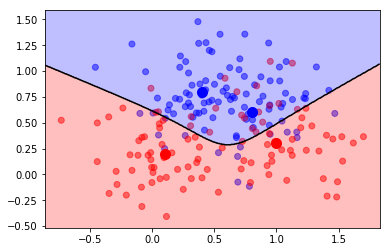

In [7]:
import mysk
Z, r = mysk.generate_points(seed = 5)
mysk.draw_points(Z, r)
mysk.draw_centers()
mysk.draw_bayes_sep_curve()

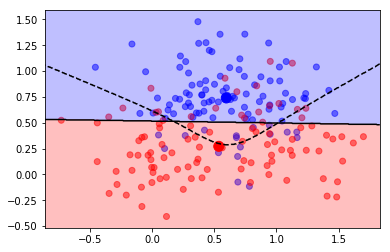

In [8]:
from sklearn import discriminant_analysis
lda_model_ex = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model_ex.fit(Z, r)

mysk.draw_points(Z, r)
mysk.draw_sep_curve(lda_model_ex)
mysk.draw_bayes()
plt.scatter(lda_model_ex.means_[:, 0], lda_model_ex.means_[:, 1], color = ['b', 'r'], s = 100)

### LDA: наши данные

In [9]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(X_train, Y_train)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

#### Важно

Для наших данных LDA выдает следующее предупреждение: "Variables are collinear"

Что это означает?
Между данными векорами признаков есть корреляция:

 - LDA вычисляет обратную матрицу в ходе регрессионного анализа. В случае, если несколько признаков образуют линейную комбинацию (или почти образуют), определитель матрицы будет принимать значения близкие к 0 или 0, что означает, что нельзя посчитать обратную матрицу
 
 - Более того, тяжелее становится проинтерпретировать полученные коэффициенты. Например: если увеличение X1 влечет за собой снижение X2, но при этом X1 & X2 увеличивают выходное значение Y: каждое изменение в X1 будет "сглаживаться" изменением X2 и эффект влияния X1 на Y будет неявно уменьшен

(0.0, 1.0)

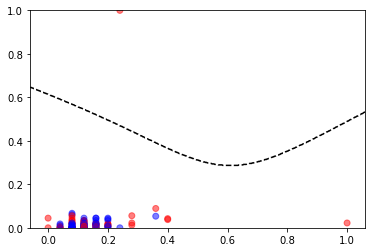

In [10]:
from numpy import array
from matplotlib.pyplot import scatter
xx0_min, xx0_max = plt.xlim()
xx1_min, xx1_max = plt.ylim()
vX = X_train.values # taking raw values from DataFrame for visualization
mysk.draw_points(vX, intY)
mysk.draw_bayes()
# plt.xlim((xx0_min, xx0_max))
plt.ylim((xx1_min, xx1_max))

#### Замечание

Так как размерность наших признаков - 41 (число столбцов), невозможно построить график в 41-мерном пространстве

На графике видно, что классы тесно пересекаются:

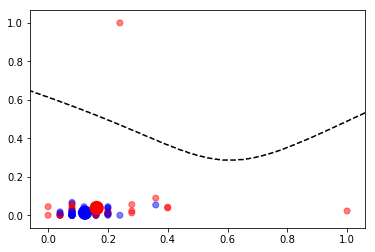

In [11]:
vX = X_train.values # taking raw values from DataFrame for visualization
mysk.draw_points(vX, intY)
mysk.draw_bayes()
plt.scatter(lda_model.means_[:, 0], lda_model.means_[:, 1], color = ['b', 'r'], s = Y.shape)
# _, features_number = X.shape
# dr.draw_sep_curve_and_reshape(model=lda_model, n_dims=features_number)

#### Средние значения признаков в получившейся модели для заданных классов

In [12]:
lda_model.means_

array([[ 0.12333333,  0.01308642,  0.        ,  0.        ,  0.77777778,
         0.19444444,  0.01388889,  0.        ,  0.01388889,  0.09722222,
         0.48611111,  0.41666667,  0.69444444,  0.04166667,  0.20833333,
         0.05555556,  0.16666667,  0.19444444,  0.38888889,  0.25      ,
         0.81944444,  0.        ,  0.18055556,  0.20833333,  0.18055556,
         0.        ,  0.41666667,  0.04166667,  0.01388889,  0.02777778,
         0.05555556,  0.        ,  0.        ,  0.04166667,  0.01388889,
         0.77777778,  0.01388889,  0.01388889,  0.09722222,  0.01388889,
         0.65277778],
       [ 0.1624    ,  0.03806844,  0.02      ,  0.02      ,  0.56      ,
         0.3       ,  0.08      ,  0.02      ,  0.        ,  0.06      ,
         0.32      ,  0.62      ,  0.76      ,  0.        ,  0.2       ,
         0.04      ,  0.14      ,  0.3       ,  0.36      ,  0.2       ,
         0.82      ,  0.        ,  0.18      ,  0.2       ,  0.08      ,
         0.02      ,  0.5    

#### Подсчет ошибок

In [13]:
err_train = np.mean(Y_train != lda_model.predict(X_train))
err_test = np.mean(Y_test != lda_model.predict(X_test))
print(err_train, err_test)

0.245901639344 0.547169811321


#### Априорные вероятности

Так как Y - бинарный: "C1" или "C2", то вероятностей 2:

${\rm Pr\,}(y="C1")$ и ${\rm Pr\,}(y="C2")$


In [14]:
print(lda_model.priors_)

[ 0.59016393  0.40983607]


#### Коэффициенты

Получившиеся коэффициенты: $w^{\top}$

Например, из уравнения: $w^{\top} x = c$

Их количество должно быть равно количеству признаков

In [15]:
print(lda_model.coef_)
_, features_number = X.shape
print("LDA coeffs. size: ", len(lda_model.coef_[0]))
print("Features size: ", features_number)

[[  2.37075776e+00  -4.58128645e+00   2.10767816e+00   5.17232886e+00
   -7.41749883e-01   1.99646192e-01   1.21301496e+00   3.04227860e+00
   -1.77944363e+00  -3.31664977e-01  -6.57247031e-01   7.51482222e-01
    1.05001210e-01  -5.40917019e-01  -2.21385970e-01   5.95563132e-01
   -3.79666938e-01   9.13463047e-01  -2.73701594e-01  -2.77886053e-01
   -2.10969343e-01  -1.86863504e-16   2.10969343e-01   1.23220214e+00
    8.90492983e-01   2.10767816e+00   1.62332323e+00   2.63104288e-01
   -4.99555485e-01   2.67989597e+00   1.20127762e+00   6.66996963e-17
    4.41092418e+00   4.92057144e+00   2.03745760e+00   3.56888495e+00
   -1.19991176e+00   1.15680894e+00   3.23290407e+00  -5.62234062e-01
   -1.05538478e+00]]
LDA coeffs. size:  41
Features size:  41


## Квадратичный дискриминантный анализ

### Пример данных и QDA

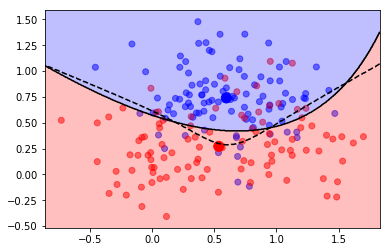

In [16]:
qda_model_ex = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model_ex.fit(Z, r)

mysk.draw_points(Z, r)
mysk.draw_sep_curve(qda_model_ex)
mysk.draw_bayes()
plt.scatter(qda_model_ex.means_[:, 0], qda_model_ex.means_[:, 1], color = ['b', 'r'], s = 100)

### QDA: наши данные

In [17]:
qda_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model.fit(X, Y)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

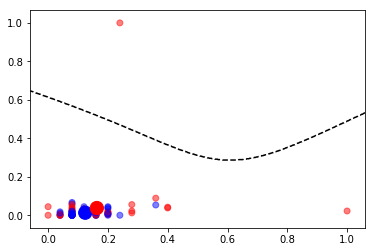

In [18]:
mysk.draw_points(vX, intY)
mysk.draw_bayes()
plt.scatter(qda_model.means_[:, 0], qda_model.means_[:, 1], color = ['b', 'r'], s = Y.shape)

#### Ошибки

In [19]:
err_train = np.mean(Y != lda_model.predict(X))
err_test = np.mean(Y_test != lda_model.predict(X_test))
print(err_train, err_test)

0.337142857143 0.547169811321


## LDA для понижения размерности

### Пример данных

In [20]:
from sklearn import datasets
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target
names = iris.target_names

lda_model = discriminant_analysis.LinearDiscriminantAnalysis(n_components = 2)
lda_model.fit(X_iris, y_iris)
X_iris_lda = lda_model.transform(X_iris) # projected data

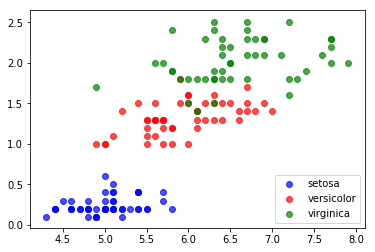

In [21]:
plt.scatter(X_iris[y_iris == 0, 0], X_iris[y_iris == 0, 3], color = 'b', label = names[0], alpha = 0.7)
plt.scatter(X_iris[y_iris == 1, 0], X_iris[y_iris == 1, 3], color = 'r', label = names[1], alpha = 0.7)
plt.scatter(X_iris[y_iris == 2, 0], X_iris[y_iris == 2, 3], color = 'g', label = names[2], alpha = 0.7)

plt.legend(loc = 4)
pass

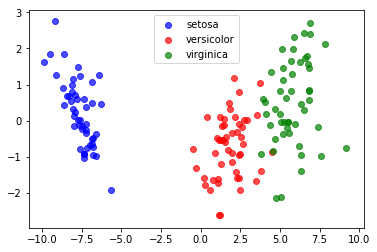

In [22]:
plt.scatter(X_iris_lda[y_iris == 0, 0], X_iris_lda[y_iris == 0, 1], color = 'b', label = names[0], alpha = 0.7)
plt.scatter(X_iris_lda[y_iris == 1, 0], X_iris_lda[y_iris == 1, 1], color = 'r', label = names[1], alpha = 0.7)
plt.scatter(X_iris_lda[y_iris == 2, 0], X_iris_lda[y_iris == 2, 1], color = 'g', label = names[2], alpha = 0.7)

plt.legend(loc = 9)
pass

### Наши данные

In [23]:
data_names = ["C1", "C2"]

lda_model2 = discriminant_analysis.LinearDiscriminantAnalysis(n_components = 2)
lda_model2.fit(X, Y)
X_projected = lda_model2.transform(X)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [24]:
print("X.shape: ", X.shape)
print("X_projected.shape: ", X_projected.shape)
print("Y.shape: ", Y.shape)

X.shape:  (175, 41)
X_projected.shape:  (175, 1)
Y.shape:  (175,)


На графике ниже видно, что данные не отличимы

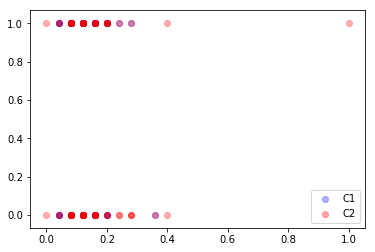

In [25]:
X_arr = X.values
plt.scatter(X_arr[Y == 'C1', 0], X_arr[Y == 'C1', 40], color = 'b', label = data_names[0], alpha = 0.3)
plt.scatter(X_arr[Y == 'C2', 0], X_arr[Y == 'C2', 40], color = 'r', label = data_names[1], alpha = 0.3)

plt.legend(loc = 4)
pass

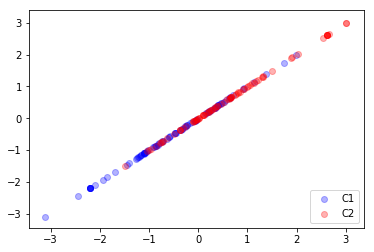

In [26]:
plt.scatter(X_projected[Y == 'C1', 0], X_projected[Y == 'C1', 0], color = 'b', label = data_names[0], alpha = 0.3)
plt.scatter(X_projected[Y == 'C2', 0], X_projected[Y == 'C2', 0], color = 'r', label = data_names[1], alpha = 0.3)

plt.legend(loc = 4)
pass

После применения проекции (LDA.transform(...)) стало возможным различить (хотя бы как-то) множество признаков:
- Y = 'C1': стремится к нижнему левому углу 
- Y = 'C2': стремится к верхнему правому углу